# 02. Model - Initial

### Importando as bibliotecas

In [1]:
import sys
import os
from pathlib import Path
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

### Configurando para serem exibidas apenas mensagens de erro no Tensor Flow

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Configurando para serem exibidas apenas mensagens de erro no Tensor Flow

### Lendo o dataset

In [3]:
df = keras.datasets.imdb # Armazenando o dataset em uma variável

In [4]:
(x_train, y_train), (x_test, y_test) = df.load_data() # Armazenando os dados do df já divididos em X e Y de treino e teste

In [5]:
word_index = df.get_word_index() # Armazenando o dicionário de palavras em uma variável

In [6]:
word_index = {chave: (valor + 3) for chave, valor in word_index.items()} # Adicionando 4 espaços no dicionário para inserir tokens especiais para NLP: PAD, START, UNK e UNUSED

In [7]:
# Adicionando os tokens especiais em suas respectivas posições
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2
word_index['<UNUSED>'] = 3

In [8]:
x_train = keras.utils.pad_sequences( # Ajustando o novo valor de x de treino para otimizar os recursos de processamento, limitando os reviews em 256 tokens (nesse caso, palavras). Para reviews menores, serão preenchidos com <PAD>. Para reviews maiores, serão cortados em 256 tokens.
    x_train, # Passando os dados que serão alterados
    value=word_index['<PAD>'], # Passando o valor que preenchera os espaços vazios caso os reviews tenham menos de 256 tokens
    padding='post', # Definindo se os reviews com menos de 256 tokens, vão ser preenchidos com <PAD> no início ou no final
    truncating='post', # Definindo se os reviews com mais de 256 tokens, vão ser cortados no início ou no final
    maxlen=256 # Definindo o número máximo de tokens
)

In [9]:
x_test = keras.utils.pad_sequences( # Ajustando o novo valor de x de teste para otimizar os recursos de processamento, limitando os reviews em 256 tokens (nesse caso, palavras). Para reviews menores, serão preenchidos com <PAD>. Para reviews maiores, serão cortados em 256 tokens.
    x_test, # Passando os dados que serão alterados
    value=word_index['<PAD>'], # Passando o valor que preenchera os espaços vazios caso os reviews tenham menos de 256 tokens
    padding='post', # Definindo se os reviews com menos de 256 tokens, vão ser preenchidos com <PAD> no início ou no final
    truncating='post', # Definindo se os reviews com mais de 256 tokens, vão ser cortados no início ou no final
    maxlen=256 # Definindo o número máximo de tokens
)

### Definindo o modelo Keras a partir de um pipeline

In [10]:
# Etapa inicial
model = keras.models.Sequential() # Instanciando o modelo

# Etapas de pré processamento
model.add(keras.layers.InputLayer(input_shape=(256,))) # Passando o shape dos dados para o modelo (Conforme definido o limite de tokens)
model.add(keras.layers.Embedding(len(word_index), 64)) # Passando o embedding para fazer a segmentação das palavras
model.add(keras.layers.GlobalAveragePooling1D()) # Adicionando o Global Average Pooling visando ajustar o shape de entrada com o de saída, partindo de 3 dimensões sendo que é esperado 2 dimensões

# Etapas de camadas ocultas
model.add(keras.layers.Dense(2, activation='sigmoid')) # Passando a camada de entrada (2 = tipos de classificação (positiva ou negativa))

model.summary() # Exibindo o resumo do treinamento

c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 256, 64)        │     5,669,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,669,762 (21.63 MB)

 Trainable params: 5,669,762 (21.63 MB)

 Non-trainable params: 0 (0.00 B)

### Compilando o modelo

In [11]:
optimizer = keras.optimizers.Adam() # Definindo o otimizador
loss = keras.losses.SparseCategoricalCrossentropy() # Definindo a função de busca
metric = keras.metrics.SparseCategoricalAccuracy() # Definindo a métrica a ser considerada durante o treinamento

model.compile(optimizer=optimizer, loss=loss, metrics=[metric]) # Compilando o modelo

### Treinando o modelo

In [12]:
# early_stop = keras.callbacks.EarlyStopping( # Configurando um callback que interrompe o treinamento do modelo caso o desempenho pare de melhorar, com base em métricas monitoradas
#     patience = 5, # Definindo o patience, que é o número de epochs consecutivas em que a métrica monitorada pode não melhorar antes de interromper o treinamento
#     verbose = 1, # Definindo o verbose para exibir a informação de quando o callback for acionado caso aconteça
#     min_delta = 1E-4, # Definindo a menor diferença aceitável para considerar que houve melhora em uma métrica monitorada
# )

history = model.fit( # Treinando o modelo e armazenando o seu resultado em uma variável
    x_train, # Passando os valores de x de treino
    y_train, # Passando os valores de y de treino
    epochs = 20, # Definindo o número máximo de epochs, ou seja, quantas vezes o modelo passará por todo o conjunto de treino durante o ajuste
    batch_size = 512, # Definindo o batch size, que é o número de amostras processadas de uma só vez antes de atualizar os pesos do modelo
    validation_split = 0.2, # Definindo a proporção dos dados de treino que será separada para validação
    verbose = 1, # Exibindo o andamento do treinamento do modelo
    # callbacks = [early_stop] # Definindo o callback com a condição de parada definida anteriormente para interromper o treinamento do modelo
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.6867 - sparse_categorical_accuracy: 0.5809 - val_loss: 0.6604 - val_sparse_categorical_accuracy: 0.7040
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.6500 - sparse_categorical_accuracy: 0.7185 - val_loss: 0.6140 - val_sparse_categorical_accuracy: 0.7410
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.6007 - sparse_categorical_accuracy: 0.7569 - val_loss: 0.5617 - val_sparse_categorical_accuracy: 0.7604
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.5453 - sparse_categorical_accuracy: 0.7801 - val_loss: 0.5144 - val_sparse_categorical_accuracy: 0.7848
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.4948 - sparse_categorical_accuracy: 0.8046 - val_loss: 0.4707 - val_sparse_categorical_accuracy: 0.8276
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.4455 - sparse_categorical_accuracy: 0.8425 - val_loss: 0.4370 - val_sparse_categorical_accuracy: 0.8384
Epoch 7/20

### Fazendo o evaluate do modelo

In [13]:
model.evaluate(x_test, y_test) # Fazendo o evaluate do modelo

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3173 - sparse_categorical_accuracy: 0.8679


[0.3179739713668823, 0.8686800003051758]

### Verificando possíveis condições de overfitting

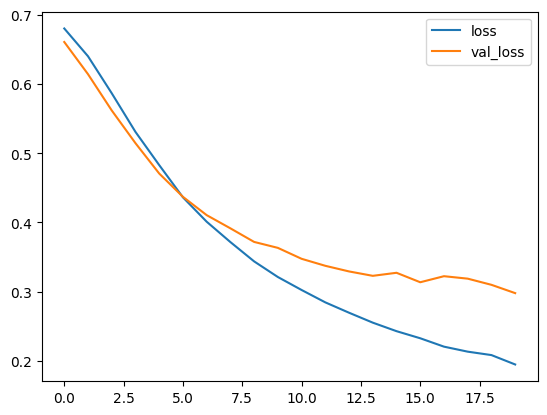

In [14]:
plt.plot(history.history['loss'], label='loss') # Plotando os valores de treino
plt.plot(history.history['val_loss'], label='val_loss') # Plotando os valores de validação
plt.legend() # Exibindo as legendas
plt.show() # Exibindo o gráfico

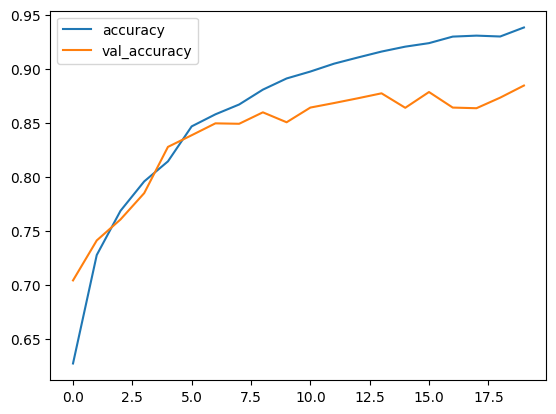

In [15]:
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy') # Plotando os valores de treino
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_accuracy') # Plotando os valores de validação
plt.legend() # Exibindo as legendas
plt.show() # Exibindo o gráfico

### Fazendo o predict do modelo com uma amostra dos dados

In [ ]:
fig, axs = plt.subplots(figsize=(12,6), nrows=4, ncols=5) # Definindo o tamanho da figura para exibir os gráficos

for i, ax in enumerate(axs.flat): # Criando uma estrutura de repetição para percorrer cada valor de x e plotar em um gráfico
    ax.imshow(x_test[i], cmap='gray') # Plotando a imagem em um gráfico em escala de cinza
    ax.set_title(f'Resposta correta: {y_test[i]}', size=10, pad=15) # Definindo o título do gráfico
    ax.axis('off') # Desativando os títulos dos eixos
    pred = model.predict(np.expand_dims(x_test[i], axis=0), verbose=0)[0] # Armazenando a previsão do modelo em uma variável
    ax.text( # Adicionando um texto com a previsão do modelo
        14, # Definindo a posição horizontal
        -4, # Definindo a posição vertical
        f'Previsão: {pred.argmax()} - {pred.max():.1%}', # Definindo o conteúdo do texto
        color='green' if pred.argmax() == y_test[i] else 'red', # Definindo a cor do texto, variando de acordo com a previsão certa ou errada
        verticalalignment = 'center', # Definindo o alinhamento vertical
        horizontalalignment = 'center', # Definindo o alinhamento horizontal
    )

fig.subplots_adjust(hspace=0.6) # Ajustando o espaço entre cada subfigura

plt.show() # Exibindo os gráficos

### Testando o modelo em imagens criadas manualmente

In [ ]:
real_images_dir = Path('../images/real_images') # Armazenando em uma variável o caminho da pasta das imagens criadas manualmente

all_pred = {} # Criando um dicionário vazio para armazenar as previsões do modelo e poder verificar as probabilidades de cada resultado posteriormente

fig, axs = plt.subplots(figsize=(12,4), nrows=2, ncols=5) # Definindo o tamanho da figura para exibir os gráficos

for i, (img, ax) in enumerate(zip(sorted(real_images_dir.glob('*.png')), axs.flat)): # Criando uma estrutura de repetição para percorrer as imagens criadas e plotar em um gráfico

    name = img.name.split('.')[0] # Armazenando em uma variável o nome da imagem com o número correto a partir do . como separador

    img = keras.preprocessing.image.load_img(
        img, target_size=(28, 28), color_mode='grayscale'
    ) # Ajustando a escala da imagem, pois o modelo foi treinado com imagens com 28 x 28 pixels, e as que fizemos possuem 128 x 128
    img_array = keras.preprocessing.image.img_to_array(img) # Convertendo a imagem para um array NumPy
    img_array = 255 - img_array # Invertendo as cores da imagem, pois o modelo foi treinado com imagens com fundo preto, e as que fizemos são com fundo branco
    img_array = tf.expand_dims(img_array, 0) # Adicionando uma dimensão extra

    pred = model.predict(img_array, verbose=0) # Armazenando o valor previsto em uma variável
    all_pred[name] = pred # Adicionando a previsão no dicionário criado anteriormente para isso

    ax.imshow(img_array[0], cmap='gray') # Plotando a imagem em um gráfico em escala de cinza
    ax.set_title(f'Resposta correta: {name}', size=10, pad=25) # Definindo o título do gráfico
    ax.axis('off') # Desativando os títulos dos eixos
    ax.text( # Adicionando um texto com a previsão do modelo
        14, # Definindo a posição horizontal
        -4, # Definindo a posição vertical
        f'Previsão: {pred.argmax()} - {pred.max():.1%}', # Definindo o conteúdo do texto
        color='green' if str(pred.argmax()) == name else 'red', # Definindo a cor do texto, variando de acordo com a previsão certa ou errada
        verticalalignment = 'center', # Definindo o alinhamento vertical
        horizontalalignment = 'center', # Definindo o alinhamento horizontal
    )

fig.subplots_adjust(hspace=0.6) # Ajustando o espaço entre cada subfigura

plt.show() # Exibindo os gráficos


### Verificando as probabilidades de resultados para cada imagem

In [ ]:
formatted_pred = { # Criando um dicionário para formatar os valores 
    key: np.array([['{:.1f}%'.format(x * 100) for x in row] for row in value]) 
    for key, value in all_pred.items()
}

for key, value in formatted_pred.items(): # Criando uma estrutura de repetição para printar os resultados de chave e valor das previsões
    print(f'{key}: {value}')